In [127]:
import finite_diff as fd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
from trace_ray import trace_ray_1D
from torch_helper import to_torch, to_torch_3D, torch_func, inner_product, angle

from scipy.integrate import cumulative_trapezoid
from scipy.special import airy
from scipy.signal import find_peaks, argrelextrema
from gauss_freud_quad import integrate_gauss_freud_quad, get_nodes_and_weights
from scipy.optimize import brentq

In [128]:
rcParams.update(mpl.rcParamsDefault)
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"],
    "font.size": 16})
rcParams['axes.titlepad'] = 20

In [129]:
from skimage.segmentation import flood

def np_inner_product(a, b):
    return np.einsum('...i,...i->...', a, b)

def np_transpose(A):
    '''return transpose of only the last two dimensions.'''
    return np.moveaxis(A, -1, -2)

def np_eye(shape):
    eye = np.zeros(shape)
    eye[..., :, :] = np.eye(shape[-1])
    return eye

def np_diag(v):
    eye = np_eye((*v.shape, v.shape[-1]))
    return eye * np.stack([v]*v.shape[-1], axis=-1)

def sgn_mask_from_seed(a, seed):
    '''returns boolean array mask for the "sign branch" connected to the seed index.
    A "sign branch" is here defined as a connected region where the sign of the array `a` is constant.
    '''
    return flood(np.signbit(a), seed)

def get_masks_of_const_sgn(a, ND = 3):
    '''returns list of boolean arrays with masks which
    subdivide the values of the array, `a`,
    into regions where the sign is constant.'''
    seed = (0, ) * ND
    regions_remaining = True
    masks = []
    while regions_remaining:
        masks.append(sgn_mask_from_seed(a, seed))
        remaining_cells = np.argwhere(np.any(masks, axis=0) == False)
        if len(remaining_cells) > 0:
            seed = tuple(remaining_cells[0])
        else:
            regions_remaining = False
    return masks

In [130]:
# Define Warm Plasma Dispersion Relation
import torch
from scipy.constants import e, m_e, epsilon_0, c

# ICs
f0 = 34.8e9
omega0 = 2*np.pi*f0
x0 = 0

# Constants
n0 = 2.07e19
T0 = 38.5*e
L_ne = 2.8434e-2
L_Te = 0.7295*L_ne
B0 = 0.511

sc_x = 1
sc_k = 1
sc_omega = 1

@torch_func
def B(x: ('scalar')):
    return B0 * torch.ones_like(x)

@torch_func
def omega_c(x: ('scalar')):
    return e*B(x)/m_e

@torch_func
def T_e(x: ('scalar')):
    # return T0
    return T0*(1 - x/L_Te)

@torch_func
def n_e(x: ('scalar')):
    return n0*(1 - x/L_ne)

@torch_func
def omega_p_squared(x: ('scalar')):
    return n_e(x) * e**2 / (epsilon_0 * m_e)

@torch_func
def v_Te_squared(x: ('scalar')):
    return 2*T_e(x)/m_e

@torch_func
def Stix_S(x: ('scalar'), omega: ('scalar')):
    return 1 - (omega_p_squared(x)/(omega**2 - (omega_c(x)**2 )))

@torch_func
def Stix_D(x: ('scalar'), omega: ('scalar')):
    return (omega_c(x)/omega) * (omega_p_squared(x)/(omega**2 - (omega_c(x)**2)))

@torch_func
def lamb(x: ('scalar'), k: ('scalar')):
    return v_Te_squared(x)/(2 * (omega_c(x)**2)) * (torch.abs(k)**2)

@torch_func
def Omega(x: ('scalar'), omega: ('scalar')):
    return omega/omega_c(x)

@torch_func
def K1_int(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    _psi = torch.linspace(0, torch.pi, 100)
    return torch.exp(-lamb(x, k)) * torch.trapezoid(torch.sin(_psi*Omega(x, omega))*torch.sin(_psi)*torch.exp(-lamb(x, k)*torch.cos(_psi)), _psi)

@torch_func
def K1(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    return (1
     + (omega_p_squared(x)/(omega_c(x)**2)) / (torch.sin(torch.pi * Omega(x, omega)))
        * (K1_int(x, k, omega))
    )

@torch_func
def D(x: ('scalar'), k: ('scalar'), omega: ('scalar')):
    _x = sc_x * x
    _k = sc_k * k
    _omega = sc_omega * omega
    return (c/_omega)**2 * (K1(_x, _k, _omega) * (torch.abs(_k)**2) - (_omega/c)**2 * (Stix_S(_x, _omega)**2 - Stix_D(_x, _omega)**2))

def get_k0(x0, omega0, kmin, kmax):
    return brentq(lambda k: D(x0, k, omega0), kmin, kmax)

#### Test Dispersion on a $(x, k, \omega)$ point

In [131]:
k0 = 10e3 / sc_k
f0 = 34.8e9 / sc_omega
omega0 = 2*np.pi*f0
x0 = 1 / sc_x

print(
    'B', B(x0),
    '\n omega_c', omega_c(x0),
    '\n n_e', n_e(x0),
    '\n omega_p_squared', omega_p_squared(x0),
    '\n Stix_S', Stix_S(x0, omega0),
    '\n Stix_D', Stix_D(x0, omega0),
    '\n lambd', lamb(x0, k0),
    '\n v_Te_squared', v_Te_squared(x0),
    '\n K1_int', K1_int(x0, k0, omega0),
    '\n K1', K1(x0, k0, omega0),
    '\n D', D(x0, k0, omega0),
)

B tensor(0.5110) 
 omega_c tensor(8.9876e+10) 
 n_e tensor(-7.0730e+20) 
 omega_p_squared tensor(-2.2510e+24) 
 Stix_S tensor(57.6540) 
 Stix_D tensor(-23.2870) 
 lambd tensor(-3.9576) 
 v_Te_squared tensor(-6.3936e+14) 
 K1_int tensor(479.5933) 
 K1 tensor(-136676.3125) 
 D tensor(-25695878.)


#### Plot Dispersion in $(k, f)$ space

In [132]:
f0 = 34.8e9 / sc_omega
omega0 = 2*np.pi*f0
x0 = 0 / sc_x

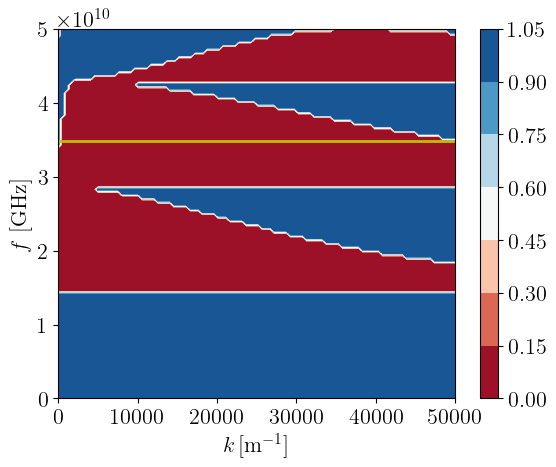

In [133]:
ki = np.linspace(0, 50000, 100) / sc_k
omegai = 2*np.pi*np.linspace(1e-6, 50e9, 100) / sc_omega
K, O = np.meshgrid(ki, omegai, indexing='ij')
D_vec = np.vectorize(D)

plt.contourf(K * sc_k, O/(2*np.pi) * sc_omega, D_vec(np.zeros_like(K), K, O) > 0, cmap='RdBu')
plt.plot(plt.gca().get_xlim(), [f0 * sc_omega, f0 * sc_omega], 'y-', linewidth=2)
plt.ylabel(r'$f$ [GHz]')
plt.xlabel(r'$k \, [\mathrm{m^{-1}}]$')
plt.colorbar()
plt.show()

#### Find initial $k_0$

In [134]:
k0 = get_k0(x0, omega0, 0, 1000 / sc_k)
k0

159.35710100713789

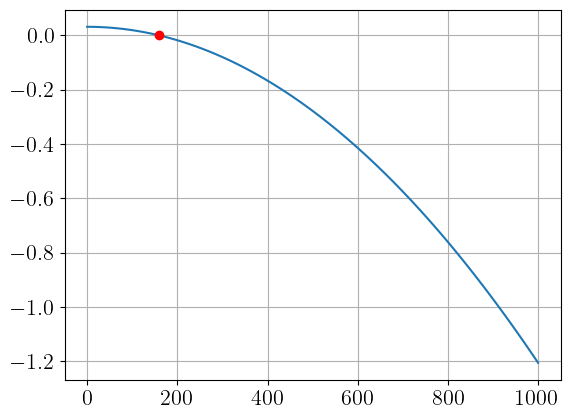

In [135]:
k_low = np.linspace(0, 1000 / sc_k, 100)
plt.plot(k_low * sc_k, D(x0, k_low, omega0))
plt.plot(k0 * sc_k, 0, 'ro')
plt.grid()
plt.show()

### Ray Tracing

In [136]:
sc_x, sc_k, sc_omega

(1, 1, 1)

In [137]:
ND = 1
nt = 4000
xs = np.zeros((nt, ND))
ks = np.zeros((nt, ND))

# ray tracing stops when it hits boundary, so we don't know
# exact number of timesteps before ray tracing has completed.
min_nt = nt

sol = trace_ray_1D(x0 = x0, k0=k0, omega0=omega0, tmin=0, tmax=40e-9*sc_omega, D=D, x_min=x0, tsteps=nt, solve_ivp_args={'method': 'LSODA'}, true_time=True, rtol=1e-9)
sol_nt = len(sol.t)
xs[:sol_nt, :] = sol.y[:ND].T
ks[:sol_nt, :] = sol.y[ND:].T
min_nt = np.min((sol_nt, min_nt))

# Clip all rays to the same number of time steps
nt = min_nt
t = sol.t[:min_nt]
xs = xs[:min_nt, :]
ks = ks[:min_nt, :]
zs = np.concatenate([xs, ks], axis=-1)
print(nt)

3612


In [138]:
traced_D = D_vec(xs, ks, omega0*np.ones_like(xs))

In [139]:
plt.plot(t / sc_omega, traced_D, label='$D(x(t), k(t), \omega)$')
plt.ylim(-0.01, 0.01)
plt.xlabel(r'$t$ [ns]')
plt.legend()
plt.grid()

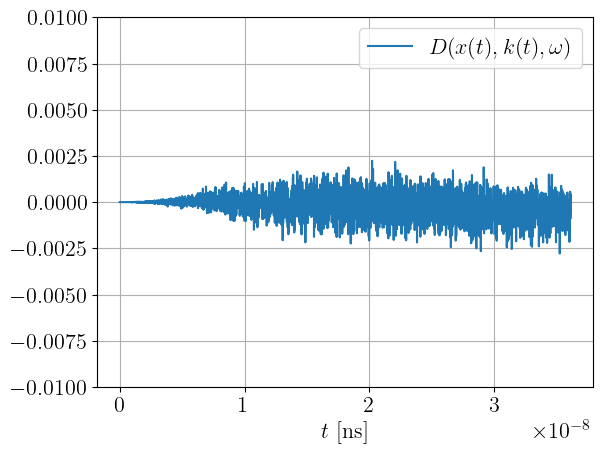

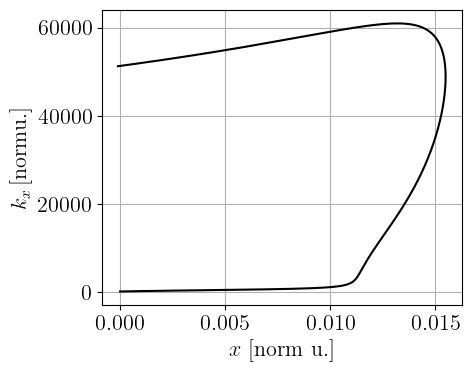

In [140]:
fig = plt.figure(figsize=(5,4))
plt.plot(xs[np.round(traced_D, 2) == 0], ks[np.round(traced_D, 2) == 0], 'k-')
plt.plot(xs[np.round(traced_D, 2) != 0], ks[np.round(traced_D, 2) != 0], 'k--')
plt.xlabel(r'$x$ [norm u.]')
plt.ylabel(r'$k_x \, \mathrm{[norm u.]}$')
plt.grid()
plt.tight_layout()
# plt.savefig('./plots/1D_warm_dispersion_manifold.png')
# plt.savefig('./plots/1D_warm_dispersion_manifold.pdf')
plt.show()

### Canonical/Symplectic Trfm

In [141]:
def gram_schmidt_orthogonalize(Q):
    N = Q.shape[-1]
    P = np.zeros(Q.shape)

    def norm(A, i):
        norms = np.sqrt(np_inner_product(A[..., i], A[..., i]))
        return np.stack([norms]*A.shape[-1], axis=-1)

    P[..., 0] = Q[..., 0]/norm(Q, 0)
    for k in range(1, N):
        P[..., k] = (Q[..., k]
                        - sum([(
            np.stack([np_inner_product(Q[..., k], P[..., j])]*N, axis=-1)
            ) * P[..., j] for j in range(k)]))
        P[..., k] = P[..., k]/norm(P, k)
    return P

def get_symplectic_tangent_trfm(zs, ND):
    gradt_z = fd.grad(zs, t)
    norms = np.sqrt(np_inner_product(gradt_z, gradt_z))
    T1 = gradt_z/np.stack([norms]*zs.shape[-1], axis=-1) # normalised grad_t z(t, y0, z0)

    # For each tau, create an identity matrix
    eye = np_eye((*zs.shape, zs.shape[-1]))
    
    # For each tau, create orthonormal basis starting from
    # single tangent vector using Gram Schmidt orthogonalization
    ONB = np.copy(eye)
    ONB[..., 0] = T1
    ONB = gram_schmidt_orthogonalize(ONB)

    # Tangent space is first 3 vectors of basis:
    # Note: Basis vectors in T are shaped as columns!
    T = ONB[..., :ND]

    symplJ = np.zeros_like(ONB)
    symplJ[..., :, :] =  np.block([
        [  np.zeros((ND, ND)),  np.eye((ND))        ],
        [  -np.eye(ND),         np.zeros((ND, ND))  ]])
    
    N = -np.matmul(symplJ, T)
    R = np.concatenate((T, N), axis=-1)
    S = np_transpose(R)
    return S

In [142]:
S = get_symplectic_tangent_trfm(zs, ND)
A, B = S[..., :ND, :ND], S[..., :ND, ND:]
gradtau_z = fd.grad(zs, t)
Q = np.block([[np_transpose(A)], [np_transpose(B)]])
R = np_transpose(Q) @ gradtau_z[..., np.newaxis]

In [143]:
phi0 = 1

In [144]:
Us, lambs, Vs = np.linalg.svd(B)
Lambdas = np_diag(lambs)
ranks = np.linalg.matrix_rank(B)

eyes = np_eye(A.shape)
eye_rhos = np.copy(eyes)
for i in range(A.shape[-1]):
    eye_rhos[ranks == i, i:, i:] = 0
eye_zetas = eyes - eye_rhos
A_tilde = np_transpose(Us) @ A @ Vs
A_zetas = (np_transpose(eye_zetas) @ A_tilde @ eye_zetas) + eye_rhos
A_rhos = (np_transpose(eye_rhos) @ A_tilde @ eye_rhos) + eye_zetas
Lambda_rhos = (np_transpose(eye_rhos) @ Lambdas @ eye_rhos) + eye_zetas

Nt = (phi0 * np.emath.sqrt(fd.grad(xs[:3, ..., 0], t)[0, ...])
    * np.exp(1j * ( cumulative_trapezoid(np_inner_product(fd.grad(xs.squeeze(), t)[..., np.newaxis], ks), t, initial=0, axis=0) ))
    ) / (
    np.emath.power((- 1j * 2*np.pi), (ranks/2)) * (
        np.emath.sqrt(
            np.linalg.det(Lambda_rhos) * np.linalg.det(A_zetas) * np.linalg.det(R)
        )
    )
)

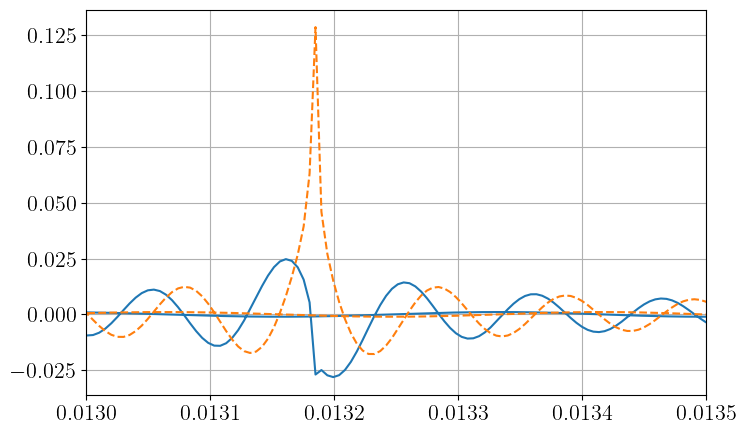

In [145]:
from math import floor, ceil
plt.figure(figsize=(8, 5))
plt.plot(xs, np.real(Nt), '-')
plt.plot(xs, np.imag(Nt), '--')
plt.xlim(13e-3,13.5e-3)
# plt.xticks(np.arange(floor(np.min(t)), ceil(np.max(t)), 0.2), rotation=90)
plt.grid()
plt.show()

### Geometrical Optics in Transformed Phase Space

In [146]:
def get_branches(J):
    branch_masks = get_masks_of_const_sgn(J, ND=1)
    J_desc = np.argsort(np.abs(J))[::-1]
    seeds = []
    branch_ranges = []
    for branch in branch_masks:
        branch_min, branch_max = np.min(np.argwhere(branch)), np.max(np.argwhere(branch))
        seed = J_desc[(branch_min <= J_desc) & (J_desc <= branch_max)][0]
        range_back, range_forward = range(seed, max(branch_min - 1, 0), -1), range(seed, min(branch_max + 1, nt - 1), +1)
        if len(range_back) > 0:
            branch_ranges.append(range_back)
            seeds.append(seed)
        if len(range_forward) > 0:
            branch_ranges.append(range_forward)
            seeds.append(seed)
    return branch_masks, seeds, branch_ranges

def neighbourhood(i, N, N_neighbours=1):
    '''returns slice corresponding to neighbourhood of i
        and index of i in sliced array.'''
    if i < 0 or i >= N:
        raise ValueError('index for neighbourhood is out of bounds')
    if i - N_neighbours < 0:
        return slice(min(1+2*N_neighbours, N)), i
    if i + N_neighbours >= N:
        return slice(max(0, N-(1+2*N_neighbours)), N), - (N-i)
    return slice(i - N_neighbours, i + N_neighbours + 1), N_neighbours

def start_angles(ddf, eps_0=0):
    alpha = np.angle(ddf(eps_0))
    sigma_p = -np.pi/4 - alpha/2 + np.pi/2
    sigma_m = -np.pi/4 - alpha/2 - np.pi/2
    return sigma_p, sigma_m

def new_angle(f, sigma, r):
    '''Calculate new direction of steepest descent
        as the descent which is closest to current direction, sigma.'''
    C_circ = lambda _r, theta: _r*np.exp(1j*theta)
    F_circ = lambda theta: np.imag(f(C_circ(r, theta)))
    sigmas = np.linspace(0, 2*np.pi, 1000)
    argmaxima = argrelextrema(F_circ(sigmas), np.greater)[0]
    new_sigma = sigmas[argmaxima[np.argmin(np.abs( ((sigma % (2*np.pi)) - sigmas[argmaxima] + np.pi) % (2*np.pi) - np.pi ))]]
    return new_sigma

def new_angles(f, sigma_p, sigma_m, l_p, l_m):
    '''Calculate new direction of steepest descent
        as the descent which is closest to current direction, sigma.'''
    r = np.mean([l_p, l_m])
    C_circ = lambda _r, theta: _r*np.exp(1j*theta)
    F_circ = lambda theta: np.imag(f(C_circ(r, theta)))
    sigmas = np.linspace(0, 2*np.pi, 1000)
    argmaxima = argrelextrema(F_circ(sigmas), np.greater)[0]
    new_sigma_p_arg = argmaxima[np.argmin(np.abs( ((sigma_p % (2*np.pi)) - sigmas[argmaxima] + np.pi) % (2*np.pi) - np.pi ))]
    argmaxima_m = argmaxima[argmaxima != new_sigma_p_arg]
    new_sigma_m_arg = argmaxima_m[np.argmin(np.abs( ((sigma_m % (2*np.pi)) - sigmas[argmaxima_m] + np.pi) % (2*np.pi) - np.pi ))]
    new_sigma_p = sigmas[new_sigma_p_arg]
    new_sigma_m = sigmas[new_sigma_m_arg]
    return new_sigma_p, new_sigma_m


def get_l_and_s(f, sigma_p, sigma_m, eps_0=0):
    Delta_F = 10

    C_p = lambda l: eps_0 + np.abs(l) * np.exp(1j*sigma_p)
    C_m = lambda l: eps_0 + np.abs(l) * np.exp(1j*sigma_m)

    F_p = lambda l: np.imag(f(C_p(l)))
    F_m = lambda l: np.imag(f(C_m(l)))

    for i in range(14):
        try:
            l_p = brentq(lambda l: F_p(l) - F_p(0) - Delta_F, 0, 10**(i))
            break
        except:
            continue
    
    for i in range(14):
        try:
            l_m = brentq(lambda l: F_m(l) - F_m(0) - Delta_F, 0, 10**(i))
            break
        except:
            continue
        
    
    s_p = Delta_F/(np.abs(l_p)**2)
    s_m = Delta_F/(np.abs(l_m)**2)

    return l_p, l_m, s_p, s_m

def get_angles_and_l_and_s(sigma_p, sigma_m, l_p, l_m, s_p, s_m, f, ddf=None, eps_0=0):
    if sigma_p == None or sigma_m == None:
        _sigma_p, _sigma_m = start_angles(ddf, eps_0)
        _l_p, _l_m, _s_p, _s_m = get_l_and_s(f, _sigma_p, _sigma_m, eps_0)
    else:
        _sigma_p, _sigma_m = new_angles(f, sigma_p, sigma_m, l_p, l_m)
        _l_p, _l_m, _s_p, _s_m = l_p, l_m, s_p, s_m
    return _sigma_p, _sigma_m, _l_p, _l_m, _s_p, _s_m

def integral(f, g, sigma_p, sigma_m, s_p, s_m, eps_0=0):
    sigma_p, sigma_m, s_p, s_m = sigma_p.astype(complex), sigma_m.astype(complex), s_p.astype(complex), s_m.astype(complex)
    h = lambda eps: g(eps) * np.exp(1j*f(eps))
    dl_p, dl_m = np.exp(1j*sigma_p)/np.sqrt(s_p), np.exp(1j*sigma_m)/np.sqrt(s_m)
    I = integrate_gauss_freud_quad(
        lambda l: (h(l*dl_p) * dl_p - h(l*dl_m) * dl_m),
        n = 10,
        dims=len(sigma_p)
    )
    return I

In [147]:
J = fd.grad(xs.squeeze(), t)
i_caust = np.argmin(np.abs(J))
t_save = t[i_caust] + np.array([-10, -2, -1, -0.3, -0.15, -0.1, -0.05, -0.01, 0, 0.01, 0.1, 0.15, 0.3, 1, 2, 10])*1e-9
i_save = [0] + [np.argmin(np.abs(t - t0)) for t0 in t_save] + [nt-1]

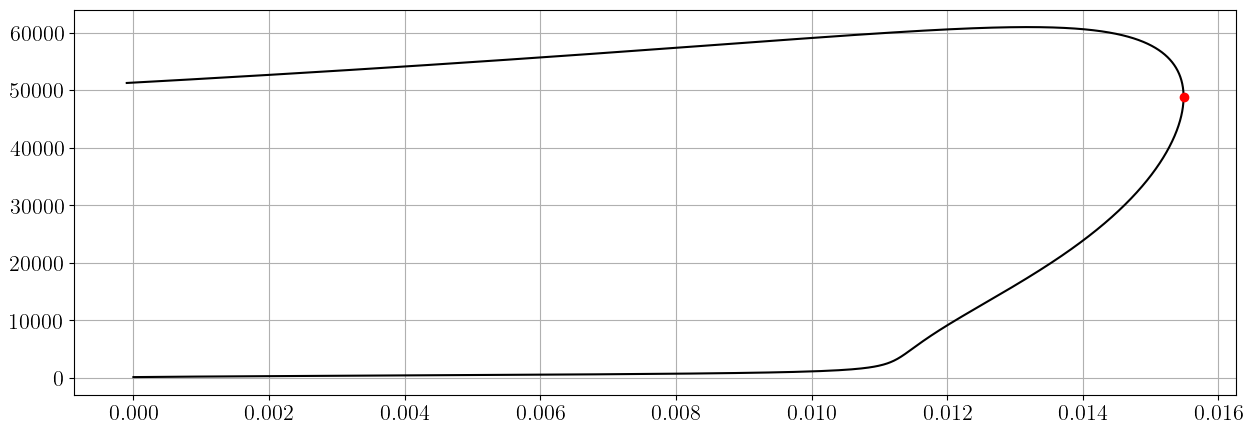

In [148]:
plt.figure(figsize=(15,5))
plt.plot(xs, ks, 'k-')
plt.plot(xs[i_caust], ks[i_caust], 'ro')
plt.grid()
plt.show()

In [149]:
from diff_func_fitters import fit_polynomial, fit_rational_func

results = []
Upsilon = np.zeros(nt, dtype=np.cdouble)
J = gradtau_z[:, :ND].squeeze()
branch_masks, seeds, branch_ranges = get_branches(J)

for seed, branch_range in zip(seeds, branch_ranges):
    print('branch:', branch_range, ' '*40, end='\r')

    sigma_p, sigma_m, l_p, l_m, s_p, s_m = np.array([None]), np.array([None]), np.array([None]), np.array([None]), np.array([None]), np.array([None])

    for it in branch_range:
        S_t1 = S[it]
        Xs_t1_all = (S_t1[:ND, :] @ zs[..., np.newaxis])
        gradtau_Xs_t1_all = fd.grad(Xs_t1_all.squeeze(), t)
        J_t1 = gradtau_Xs_t1_all
        mask_t1 = sgn_mask_from_seed(J_t1, (it)) # get current branch
        it1 = int(np.argwhere(t[mask_t1] == t[it]))
        
        Phi_t1 = np.emath.sqrt(J_t1[it]/J_t1[mask_t1]) # Amplitude set to 1 at tau = t1

        Xs_t1 = Xs_t1_all[mask_t1]
        gradtau_Xs_t1 = gradtau_Xs_t1_all[mask_t1][..., np.newaxis]
        Ks_t1 = (S_t1[ND:, :] @ zs[mask_t1, :, np.newaxis])
        int_0_to_tau = cumulative_trapezoid(Ks_t1.squeeze()*gradtau_Xs_t1.squeeze(), t[mask_t1], initial=0, axis=0)
        Theta_t1 = int_0_to_tau - int_0_to_tau[it1]
        
        rho = ranks[it]
        a_rho = A_rhos[it, :rho, :rho]
        Lambda_rho = Lambda_rhos[it, :rho, :rho]
        eps_t1 = Xs_t1 - Xs_t1[it1]
        eps_rho = eps_t1[:, :rho]
        Ks_rho = Ks_t1[:, :rho]
        f_t1 = Theta_t1 + (
                - ((1/2) * np_transpose(eps_rho[..., np.newaxis]) @ a_rho @ np.linalg.inv(Lambda_rho) @ eps_rho[..., np.newaxis]).squeeze()
                - (np_transpose(eps_rho[..., np.newaxis]) @ Ks_rho[it1, ..., np.newaxis]).squeeze()
                ).squeeze()
        
        # f_fit = fit_rational_func(eps_rho.squeeze(), f_t1.squeeze(), L=4, M=3, optimize=False)
        f_fit = fit_polynomial(eps_rho.squeeze(), f_t1.squeeze(), deg=3, exclude_degrees=[1])
        # f_fit = fit_polynomial(eps_rho.squeeze(), f_t1.squeeze(), deg=6)
        
        # g_fit_Re = fit_polynomial(eps_rho.squeeze(), np.real(Phi_t1**(-4)), deg=3)
        # g_fit_Im = fit_polynomial(eps_rho.squeeze(), np.imag(Phi_t1**(-4)), deg=3)
        # g_fit = lambda eps: np.emath.power(g_fit_Re(eps) + 1j*g_fit_Im(eps), -1/4)
        g_fit = fit_rational_func(eps_rho.squeeze(), Phi_t1.squeeze(), L=2, M=1, optimize=False)

        ddf_fit = f_fit.deriv(axis=0, order=2)
        
        for l in range(rho):
             sigma_p[l], sigma_m[l], l_p[l], l_m[l], s_p[l], s_m[l] = get_angles_and_l_and_s(sigma_p[l], sigma_m[l], l_p[l], l_m[l], s_p[l], s_m[l], f_fit, ddf_fit)
        
        if it in i_save:
            results.append({'t1': t[it], 'it': it, 'mask_t1': mask_t1, 'it1': it1,
                            'Xs_t1': Xs_t1, 'Ks_t1': Ks_t1, 'eps_rho': eps_rho,
                            'sigma_p': np.copy(sigma_p), 'sigma_m': np.copy(sigma_m), 'l_p': np.copy(l_p), 'l_m': np.copy(l_m), 's_p': np.copy(s_p), 's_m': np.copy(s_m),
                            'f_t1': f_t1, 'f_fit': f_fit, 'Theta_t1': Theta_t1, 'Phi_t1': Phi_t1, 'g_fit': g_fit, 'ddf_fit': ddf_fit})
        Upsilon[it] = integral(f_fit, g_fit, sigma_p[:rho], sigma_m[:rho], s_p[:rho], s_m[:rho])

In [150]:
xi = np.linspace(np.min(xs[..., 0])-1, np.max(xs[..., 0])+1, 10000)

In [151]:
from scipy.interpolate import interp1d
branches = [interp1d(xs[mask].squeeze(), Nt[mask] * Upsilon[mask], bounds_error=False, fill_value='extrapolate') for mask in branch_masks]

def interp_field(x):
    return sum(f(x) for f in branches)

phi0 = 1
A0 = phi0/interp_field(0e-3)

def field(x):
    return A0 * interp_field(x)

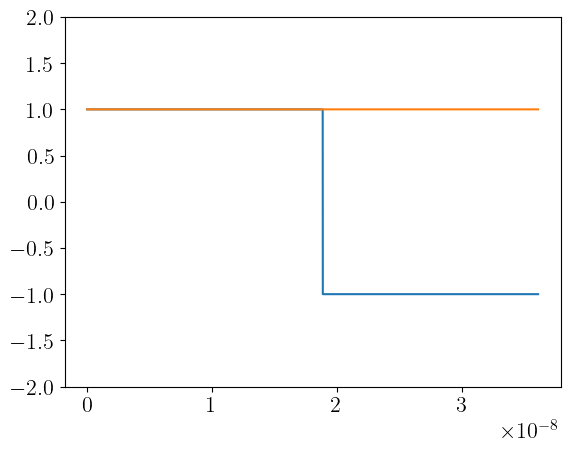

In [152]:
plt.plot(t, B.squeeze())
plt.plot(t, Lambda_rhos.squeeze())
plt.ylim(-2, 2)
plt.show()

/Users/rune.hoejlund/opt/anaconda3/envs/ray-tracer/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


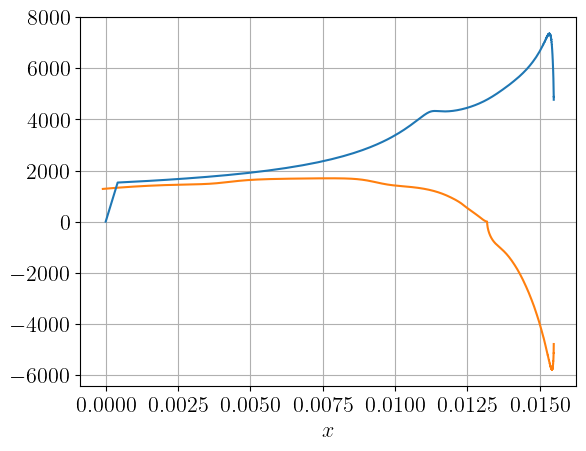

In [153]:
plt.plot(xs[branch_masks[1]], Upsilon[branch_masks[1]], '-', color='tab:orange')
plt.plot(xs[branch_masks[0]], Upsilon[branch_masks[0]], '-', color='tab:blue')
plt.xlabel(r'$x$')
plt.grid()
plt.show()

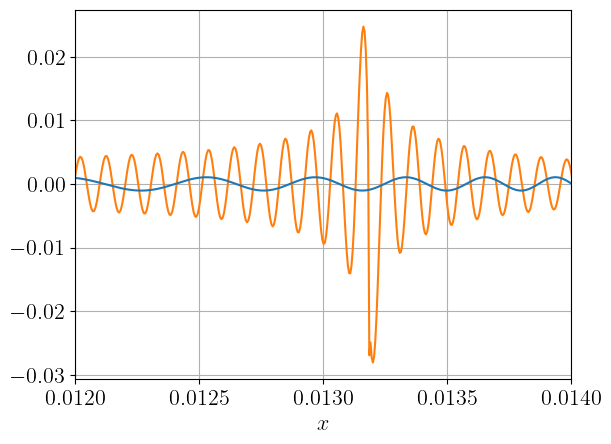

In [154]:
plt.plot(xs[branch_masks[1]], Nt[branch_masks[1]], '-', color='tab:orange')
plt.plot(xs[branch_masks[0]], Nt[branch_masks[0]], '-', color='tab:blue')
plt.xlabel(r'$x$')
plt.xlim(12e-3,14e-3)
plt.grid()
plt.show()

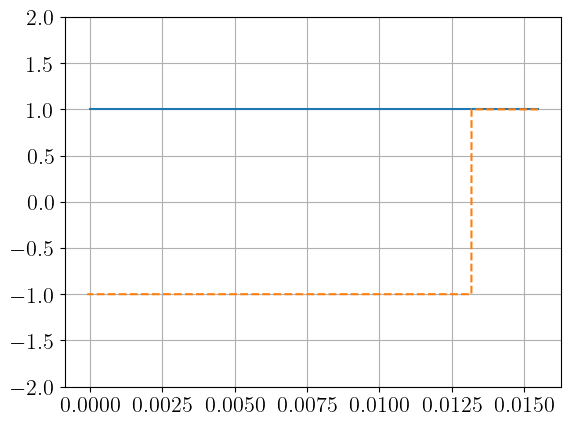

In [155]:
plt.plot(xs[branch_masks[0], :], B[branch_masks[0]].squeeze(), '-', label=r'$B$')
plt.plot(xs[branch_masks[1], :], B[branch_masks[1]].squeeze(), '--', label=r'$B$')
plt.ylim(-2,2)
plt.grid()
plt.show()

In [156]:
from scipy.signal import hilbert

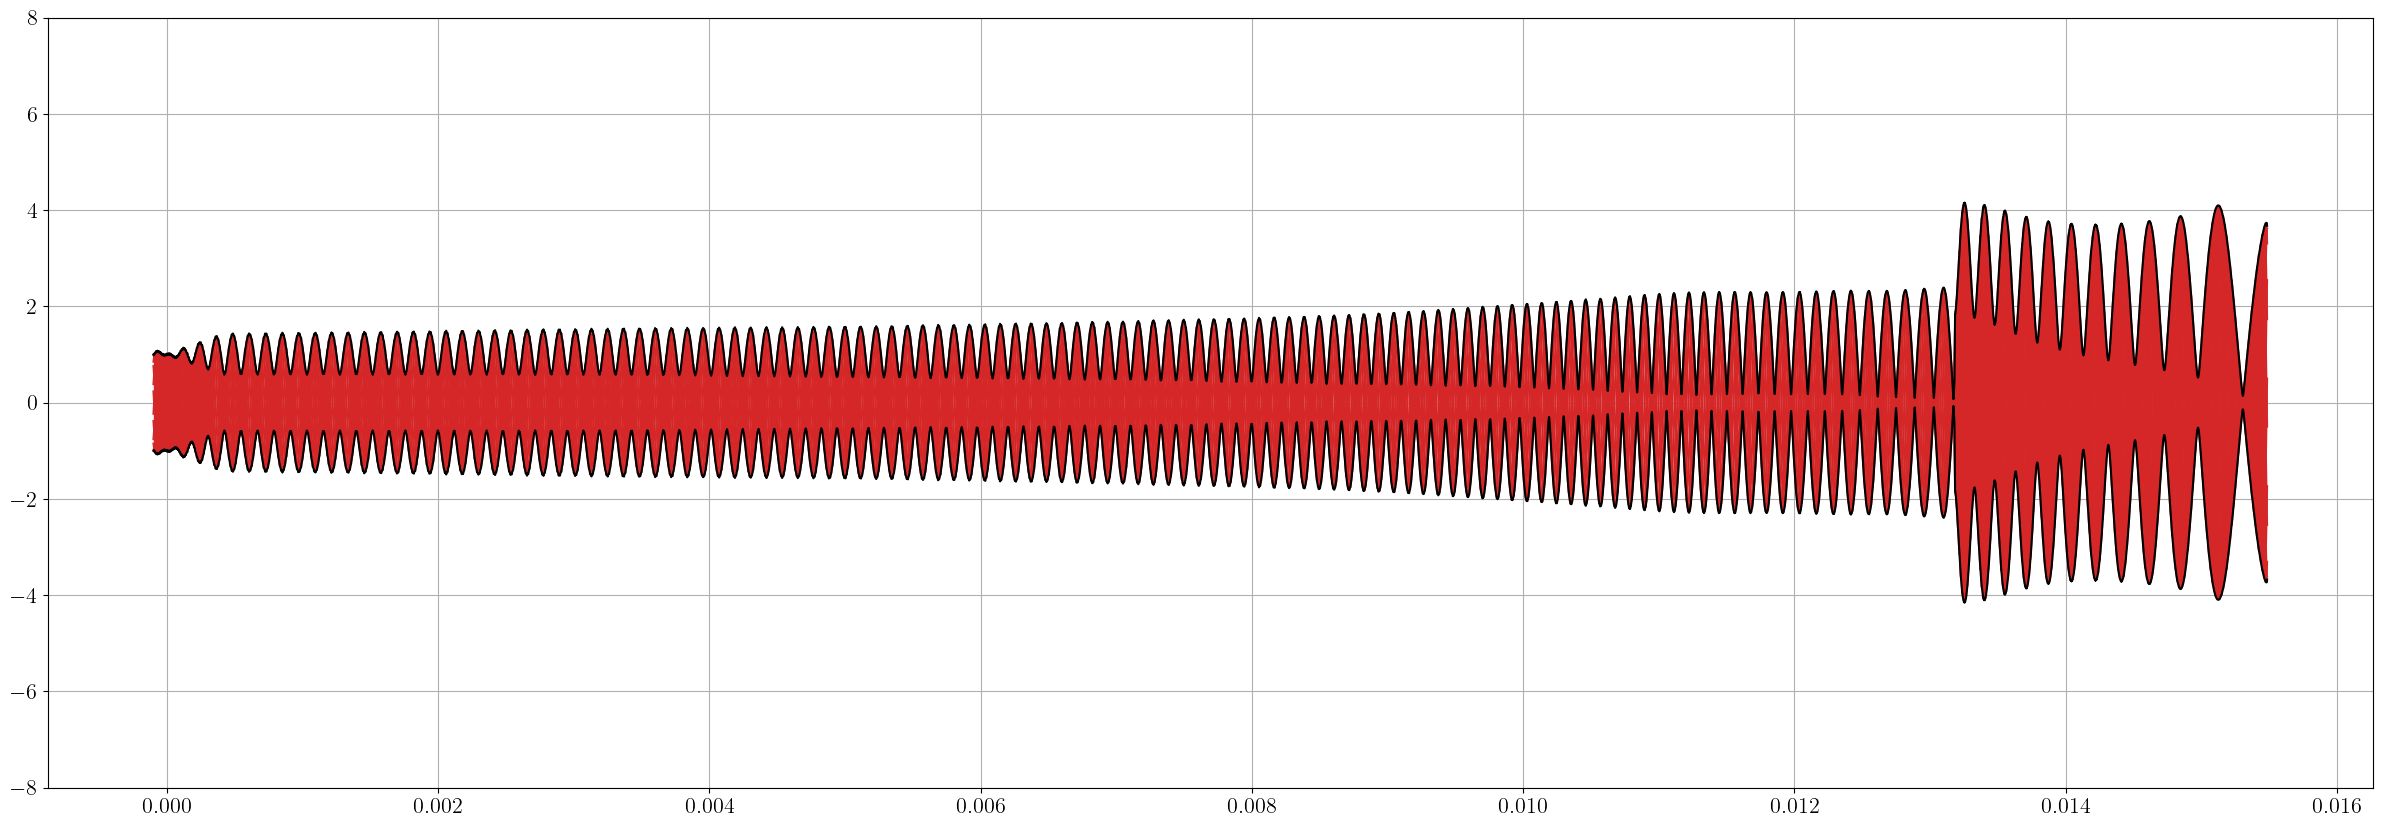

In [160]:
plt.figure(figsize=(30, 10))
xi = np.linspace(np.min(xs), np.max(xs), 10000)

N_phases = 10
for i in range(N_phases):
    plt.plot(xi, np.real(np.exp(1j*i*2*np.pi/N_phases)*field(xi)), '-', color='tab:red', label='real sum')

plt.plot(xi, np.abs(np.exp(1j*i*2*np.pi/N_phases)*field(xi)), 'k-', label='real sum')
plt.plot(xi, -np.abs(np.exp(1j*i*2*np.pi/N_phases)*field(xi)), 'k-', label='real sum')

# plt.plot(xi, np.real(field(xi)), '-', color='tab:red', label='real sum')

# plt.plot(xi, np.imag(field(xi)), '--', color='grey', label='imag sum')
# plt.plot(xs[branch_masks[0], :], np.real(A0*Nt[branch_masks[0]]*Upsilon[branch_masks[0]]), '-', color='tab:blue', label='real in')
# plt.plot(xs[branch_masks[1], :], np.real(A0*Nt[branch_masks[1]]*Upsilon[branch_masks[1]]), '-', color='tab:orange', label='real out')
# plt.plot(xs[branch_masks[0], :], np.imag(A0*Nt[branch_masks[0]]*Upsilon[branch_masks[0]]), '--', color='lightgrey', label='imag in')
# plt.plot(xs[branch_masks[1], :], np.imag(A0*Nt[branch_masks[1]]*Upsilon[branch_masks[1]]), '--', color='lightgrey', label='imag out')
# plt.xlim(12e-3, 15e-3)
plt.ylim(-8, 8)
# plt.legend()
plt.grid()
plt.show()

In [158]:
C = lambda l, sigma_p, sigma_m, s_p, s_m: np.abs(l) * np.piecewise(l, [l <= 0, l > 0], [lambda l: np.exp(1j*sigma_m)/np.emath.sqrt(s_m), lambda l: np.exp(1j*sigma_p)/np.emath.sqrt(s_p)])
C_R = lambda l, sigma_p, sigma_m, s_p, s_m: np.real(C(l, sigma_p, sigma_m, s_p, s_m))
C_I = lambda l, sigma_p, sigma_m, s_p, s_m: np.imag(C(l, sigma_p, sigma_m, s_p, s_m))

In [159]:
# epsmax = np.round(np.mean([1/np.emath.sqrt(s_m[0]), 1/np.emath.sqrt(s_p[0])]), -3)
# eps_R = np.linspace(-5*epsmax,5*epsmax, 1000)
# eps_I = np.linspace(-5*epsmax,5*epsmax, 1000)
# Eps_R, Eps_I = np.meshgrid(eps_R, eps_I)
# Eps = Eps_R + 1j*Eps_I
# l_j, _ = get_nodes_and_weights(n=10)
# l_j = l_j.astype(np.complex_)

# ncols, nrows = 7, 3
# fig = plt.figure(1, figsize=(ncols*3,nrows*2))
# fig2 = plt.figure(2, figsize=(ncols*3.5,nrows*3))
# fig3 = plt.figure(3, figsize=(ncols*3.5,nrows*3))
# fig4 = plt.figure(4, figsize=(ncols*3.5,nrows*3))
# fig5 = plt.figure(5, figsize=(ncols*3.5,nrows*3))

# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig.add_subplot(nrows, ncols, 1 + i)
#     t1, it, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
#     k = ks[it, 0]
#     eps_rho = eps_rho.squeeze()
#     ax.plot(eps_rho, f_t1, 'k-')
#     ax.plot(eps_rho, f_fit(eps_rho), '--', color='tab:orange')
#     ax.set_title('$t = ' + str(np.round((t1 - t[i_caust])*1e9,2)) + '$')
#     ax.set_xlabel(r'$\epsilon$')
#     ax.grid()
# fig.tight_layout()

# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig2.add_subplot(nrows, ncols, 1 + i)
#     ax.axis('equal')
#     t1, mask_t1, eps_rho, f_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m, s_p, s_m = (result[key] for key in ['t1', 'mask_t1', 'eps_rho', 'f_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m', 's_p', 's_m'])
#     eps_rho = eps_rho.squeeze()
#     contour_plot = ax.contourf(Eps_R, Eps_I, -np.imag(f_fit(Eps.reshape(-1, 1)).reshape(Eps.shape)), cmap='RdBu', levels=20)
#     fig.colorbar(contour_plot, ax=ax)
#     ax.set_title('$t = ' + str(np.round((t1 - t[i_caust])*1e9,2)) + '$ ns')
#     # ax.set_xlabel(r'$\mathrm{Re}(\epsilon)$')
#     # ax.set_ylabel(r'$\mathrm{Im}(\epsilon)$')

#     # Plot node points along integral path
#     ax.plot(C_R(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(-l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
#     ax.plot(C_R(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), C_I(l_j, sigma_p[0], sigma_m[0], s_p[0], s_m[0]), 'ow')
# fig2.tight_layout()

# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig3.add_subplot(nrows, ncols, 1 + i)
#     t1, it, mask_t1, eps_rho, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
#     eps_rho = eps_rho.squeeze()
#     ax.plot(eps_rho, Phi_t1, 'k-')
#     ax.plot(eps_rho, g_fit(eps_rho), '--', color='tab:orange')
#     ax.set_title(r'$\Phi(t = ' + str(np.round((t1 - t[i_caust])*1e9,2)) + '$ ns$, \\epsilon)$')
#     ax.set_xlabel(r'$\epsilon$')
#     ax.grid()
# fig3.tight_layout()

# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig4.add_subplot(nrows, ncols, 1 + i)
#     t1, it, mask_t1, eps_rho, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
#     eps_rho = eps_rho.squeeze()
#     ax.plot(eps_rho, fd.grad(f_t1, eps_rho), 'k-')
#     ax.plot(eps_rho, f_fit.deriv(axis=0, order=1)(eps_rho), '--', color='tab:orange')
#     ax.set_title('$t = ' + str(np.round((t1 - t[i_caust])*1e9,2)) + '$ ns')
#     ax.set_xlabel(r'$\epsilon$')
#     ax.grid()
# fig4.tight_layout()


# for i, result in enumerate(results):
#     # Plot $- Im{ f(eps,p) }$ (imaginary part of phase function)
#     ax = fig5.add_subplot(nrows, ncols, 1 + i)
#     t1, it, mask_t1, eps_rho, Theta_t1, f_t1, Phi_t1, f_fit, ddf_fit, g_fit, sigma_p, sigma_m = (result[key] for key in ['t1', 'it', 'mask_t1', 'eps_rho', 'Theta_t1', 'f_t1', 'Phi_t1', 'f_fit', 'ddf_fit', 'g_fit', 'sigma_p', 'sigma_m'])
#     eps_rho = eps_rho.squeeze()
#     k = ks[it, 0]
#     ax.plot(eps_rho, Theta_t1, 'k-')
#     ax.set_title(r'$\Theta(t = ' + str(np.round((t1 - t[i_caust])*1e9,2)) + '$ ns$, \\epsilon)$')
#     ax.set_xlabel(r'$\epsilon$')
#     ax.grid()
# fig5.tight_layout()

# plt.show()